# Andrew Cohen 3/17/21
# Assignment: Fitting with a reduced set of features

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from dscribe.descriptors import CoulombMatrix
from ase.io.xyz import read_xyz
from io import StringIO
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import perf_counter

## Problem 1: Fitting a Coulomb Matrix

Load in our QM9 dataset

In [2]:
#Load molecules from QM9 Database
data = pd.read_json(r'C:\Users\ascoh\Desktop\UChicago\Academics\2020-21\Q2 2021\AI for MatSci\Datasets\qm9.json.gz', lines=True)
print(f'Loaded {len(data)} molecules')

Loaded 25000 molecules


In [3]:
#Convert the data into ASE "Atoms" objects.
#We need the 3D coordinates of each molecule, which are stored in the XYZ format.

data['xyz'].iloc[0]

data['atoms'] = data['xyz'].map(lambda x: next(read_xyz(StringIO(x))))  # Lambda makes a temporary function
#The read_xyz function takes a file as input and returns a generator of Atoms object.
#We turn our string-format into a file-like object using StringIO and call next to remove the data from the generator.

and compute the [Coulomb matrix](https://singroup.github.io/dscribe/latest/tutorials/coulomb_matrix.html) for each entry.

In [4]:
%%time
cm = CoulombMatrix(40, permutation='eigenspectrum')
cms = cm.create(data['atoms'], n_jobs=2)  # Runs in parallel with 2 workers  # 40 defines the size of the array

data['cm'] = cms.tolist()  #.tolist()  # Makes it possible to set array values in a Pandas dataframe

Wall time: 51 s


Set maximum number of atoms to be 40. (QM9 dataset encompasses molecules with up to nine “heavy” atoms from the range C, O, N and F. So the molecule having most atoms would simply be Nonane, C<sub>9</sub>H<sub>20</sub>.)

In [5]:
#Reduces data to only atoms with a size of 40 or less
data_40 = data.query(f'n_atom<={40}')

Make a test set of 1000 entries.

Fit a model with 100 parameters to predict the HOMO energy (`'homo'`) using [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) regression with an RBF kernel. Make sure to fit the $\alpha$ and $\gamma$ parameters using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [6]:
#Initiliaze our RBF Kernel
model_rbf = Pipeline([
    ('scale', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

In [7]:
train_data, test_data = train_test_split(data_40, train_size=100, test_size=1000)

In [8]:
# np.vstack converts list to a big matrix
model_rbf.fit(np.vstack(train_data['cm']), train_data['homo'])

Pipeline(steps=[('scale', StandardScaler()),
                ('krr', KernelRidge(kernel='rbf'))])

In [9]:
gs = GridSearchCV(
    model_rbf,  # The model I would like to tune
    {'krr__gamma': np.logspace(-6, 0, 16), 'krr__alpha': np.logspace(-6, 0, 16)},  # The parameters to be adjusted
    cv=10,  # How I perform the cross-validation (here: 10-fold cross-validation),
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

In [10]:
%%time
gs.fit(np.vstack(train_data['cm']), train_data['homo']);

Wall time: 24 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('krr', KernelRidge(kernel='rbf'))]),
             param_grid={'krr__alpha': array([1.00000000e-06, 2.51188643e-06, 6.30957344e-06, 1.58489319e-05,
       3.98107171e-05, 1.00000000e-04, 2.51188643e-04, 6.30957344e-04,
       1.58489319e-03, 3.98107171e-03, 1.00000000e-02, 2.51188643e-02,
       6.30957344e-02, 1.58489319e-01, 3.98107171e-01, 1.00000000e+00]),
                         'krr__gamma': array([1.00000000e-06, 2.51188643e-06, 6.30957344e-06, 1.58489319e-05,
       3.98107171e-05, 1.00000000e-04, 2.51188643e-04, 6.30957344e-04,
       1.58489319e-03, 3.98107171e-03, 1.00000000e-02, 2.51188643e-02,
       6.30957344e-02, 1.58489319e-01, 3.98107171e-01, 1.00000000e+00])},
             scoring='neg_mean_squared_error')

In [11]:
y_pred = gs.best_estimator_.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$E_{atom}$, ML (Ha)')

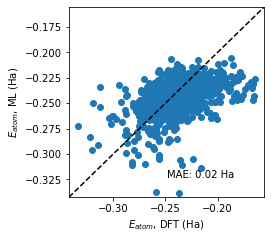

In [12]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['homo'], y_pred)

# Make a y=x line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(y_pred, test_data["homo"]):.2f} Ha',
       transform=ax.transAxes)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

Repeat the fitting process 16 times using different samples of 100 entries.

In [13]:
RBF_results = []

gs = GridSearchCV(
    model_rbf,  # The model I would like to tune
    {'krr__gamma': np.logspace(-6, 0, 16), 'krr__alpha': np.logspace(-6, 0, 16)},  # The parameters to be adjusted
    cv=10,  # How I perform the cross-validation (here: 10-fold cross-validation),
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

for step in tqdm(range(16)):
    train_data, test_data = train_test_split(data_40, train_size=100, test_size=1000)
    #model_rbf.fit(np.vstack(train_data['cm']), train_data['homo'])
    gs.fit(np.vstack(train_data['cm']), train_data['homo']);
    
    y_pred = gs.best_estimator_.predict(np.vstack(test_data['cm']))
    
    params = pd.DataFrame(gs.cv_results_['params'])
    
    RBF_results.append({
        'Step': step,
        'Gamma': params['krr__gamma'],
        'Best Gamma': gs.best_params_['krr__gamma'],
        'Alpha': params['krr__alpha'],
        'Best Alpha': gs.best_params_['krr__alpha'],
        'MTS': -gs.cv_results_['mean_test_score'],
        'MAE': mean_absolute_error(test_data['homo'], y_pred),
        'Prediction': y_pred})
        
        
RBF_df = pd.DataFrame(RBF_results)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [06:20<00:00, 23.75s/it]


Plot three histrograms of the optimized $\alpha$, $\gamma$ parameters and the MAE on a separate test set, respectively.

Text(0.5, 1.0, 'MAE')

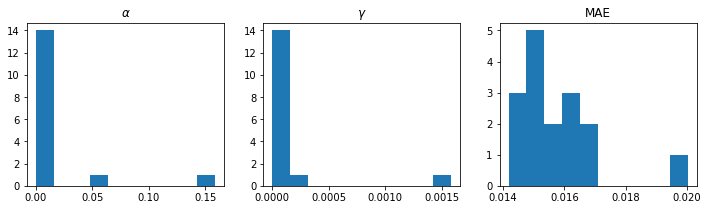

In [14]:
fig, axs = plt.subplots(1,3, figsize=(12,3))

ax = axs[0]
n, bins, patches = ax.hist(RBF_df['Best Alpha'])
ax.set_title(r'$\alpha$')

ax = axs[1]
n, bins, patches = ax.hist(RBF_df['Best Gamma'])
ax.set_title(r'$\gamma$')

ax = axs[2]
n, bins, patches = ax.hist(RBF_df['MAE'])
ax.set_title('MAE')

### Q1

- Do the optimized model parameters change with different subsets?

The optimized parameters do change with different subsets. You can see this because there is a spread in the histogram. If parameter optimization was inependent of subset, only one parameter value would be represented on the histogram.
    
- How large of a variation do you observe in the hyperparameters ($\alpha$, $\gamma$)?
    
There is minimal variation. The majority of subsets result in the same hyperparameters.
    
- Can we use the same set of parameters for all subsets of 100 entries?
    
We cannot use the same set of parameters for all subsets because clearly, different parameters optimize different subsets. By looking at the MAE histogram we can see that the subsets and hyperparameters do affect model performance.

## Problem 2: Plot a learning curve

Fit the Coulomb Matrix model using randomly-selected training sets of 10, 100, and 1000 entries, each training for 4 replicates.

In [15]:
# Set up the test sizes we will evaluate for the learning curve
train_sizes = [10, 100, 1000]

# Prepare a standard test set
train_data, test_data = train_test_split(data_40, test_size=500, random_state=1) 

# Avoids warnings about setting values of a copy
test_data = test_data.copy()

# Loop over the test sizes
results = []
for ts in tqdm(train_sizes):
    # Split off some training data
    train_subset = train_data.sample(ts, random_state=1)
    
    #Init model
    gs = GridSearchCV(
    model_rbf,  # The model I would like to tune
    {'krr__gamma': np.logspace(-6, 0, 16), 'krr__alpha': np.logspace(-6, 0, 16)},  # The parameters to be adjusted
    cv=10,  # How I perform the cross-validation (here: 10-fold cross-validation),
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
    )
    
    #for step in (range(4)):
    # Fit the model
    train_time = perf_counter()
    #model_rbf.fit(np.vstack(train_subset['cm']), train_subset['homo'])
    gs.fit(np.vstack(train_subset['cm']), train_subset['homo'])
    train_time = perf_counter() - train_time

    # Evaluate the model on the test set
    test_time = perf_counter()
    test_data['homo_pred'] = gs.best_estimator_.predict(np.vstack(test_data['cm']))
    test_time = perf_counter() - test_time

    params = pd.DataFrame(gs.cv_results_['params'])

    # Store performance information
    results.append({
            'train_size': ts,
            'train_time': train_time,
            'test_time': test_time,
            'Alpha': params['krr__alpha'],
            'Best Alpha': gs.best_params_['krr__alpha'],
            'Gamma': params['krr__gamma'],
            'Best Gamma': gs.best_params_['krr__gamma'],
            'mae': mean_absolute_error(test_data['homo'], test_data['homo_pred'])
        })

results = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [04:17<00:00, 85.81s/it]


### Q2
Plot how the averaged model accuracy on a test set, training time and inference times change as a function of training set size.

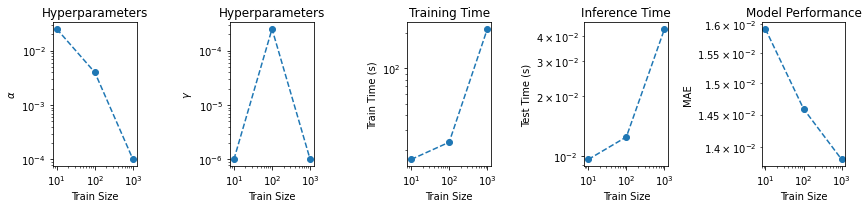

In [43]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3.))

ax = axs[0]
ax.loglog(results['train_size'], results['Best Alpha'], '--o')
ax.set_ylabel(r'$\alpha$')
ax.set_title('Hyperparameters')

ax = axs[1]
ax.loglog(results['train_size'], results['Best Gamma'], '--o')
ax.set_ylabel(r'$\gamma$')
ax.set_title('Hyperparameters')

ax = axs[2]
ax.loglog(results['train_size'], results['train_time'], '--o')
#p = linregress(np.log(results['train_size'].iloc[-3:]), np.log(results['train_time'].iloc[-3:]))
#ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('Train Time (s)')
ax.set_title('Training Time')

ax = axs[3]
ax.loglog(results['train_size'], results['test_time'], '--o')
#p = linregress(np.log(results['train_size'].iloc[-3:]), np.log(results['test_time'].iloc[-3:]))
#ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('Test Time (s)')
ax.set_title('Inference Time')

ax = axs[4]
ax.loglog(results['train_size'], results['mae'], '--o')
#p = linregress(np.log(results['train_size'].iloc[-3:]), np.log(results['test_time'].iloc[-3:]))
#ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('MAE')
ax.set_title('Model Performance')

for ax in axs:
    ax.set_xlabel('Train Size')

fig.tight_layout()
#fig.savefig('figures/fchl-scaling.svg')

## Problem 3: Optimize the training set.

We are going to use a genetic algorithm to determine an optimized training set with $100$ entries.

First, separate off a "validation set" of 1000 entries from the training set that we will use to assess the performance of our specially-chosen training sets.

In [17]:
data_valid = data_40.sample(1000)
data_new = data_40.copy()
data_new = data_new.drop(data_valid.index)

In [24]:
train_data, test_data = train_test_split(data_40, train_size = 100, test_size = 1000)

Now, implement a function that will accept a list of points from the training set by their index and produce the score of that model on the validation set using MAE. This function will be used by the genetic algorithm to score each selection of points.

In [34]:
def evaluate_subset(points: list, model, train_data: pd.DataFrame, test_data: pd.DataFrame) -> float:

    test_subset = []
    train_subset = []
    for index in points:
        train_subset.append(train_data.iloc[index])
        #test_subset.append(test_data.iloc[index])
    train_subset_df = pd.DataFrame(train_subset)
    test_subset_df = pd.DataFrame(test_subset)
    X_train = np.vstack(train_subset_df['cm'])
    #y_test = np.vstack(test_subset_df['homo'])
    
    
    predictions = gs.best_estimator_.predict(X_train)
    MAE = mean_absolute_error(test_data['homo'].sample(len(train_data)), predictions)
    return MAE
    
    """Test a subset of points

    Args:
        points: Which points from the train_data to sample
        model: Model to use for testing
        train_data: All available training points
        test_data: Data used to test the model
    Returns:
        MAE on the test set
    """

Next, run the genetic algorithm code provided at the end of this document 

In [20]:
from random import sample

def mutate(points: set, total: int, fraction: float = 0.1) -> set:
    """Mutate a set of points

    Mutates from selecting points randomly from the dataset

    Args:
        points: Set of points to be mutated
        total: Total number of samples to choose from in dataset
        fraction: How many points to re-select
    """

    # Remove the desired amount of points
    n_to_remove = int(len(points) * fraction)
    to_remove = sample(points, k=n_to_remove)
    new_points = points.difference(to_remove)

    # Add more points to the set
    available_choices = set(range(total)).difference(new_points)
    new_points.update(sample(available_choices, n_to_remove))

    return new_points

def crossover(parent_a: set, parent_b: set):
    """Perform a crossover operation

    Randomly chooses points from both parents

    Args:
        parent_a: One choice of points
        parent_b: Another choice of points
    Returns:
        A new set that combines both parents
    """

    # Combine all points from each parents
    options = parent_a.union(parent_b)

    # Pick randomly from the combined set
    return set(sample(options, len(parent_a)))

Genetic algorithms work by applying crossover and mutation to the best-performing entries of each generation, and repeating the process over many generations. The idea is that best-performing traits ("genes") are present in the later generations.


In [21]:
valid_data = data_valid

In [35]:
# Defining options
n_generations = 50
pop_size = 8
dataset_size = 100

# Array in which to store all results
all_options = []

# Make an initial population
#  Creates sets where each have different entries pull from the full dataset
population = np.array([set(sample(range(len(train_data)), k=100)) for i in range(pop_size)])

# Loop over the generations
for gen in tqdm(range(n_generations), desc='generation'):
    # Score each member of the population
    scores = [
        evaluate_subset(list(s), gs, train_data, valid_data) for s 
        in population
    ]

    # Store the results in the history
    for i, s in enumerate(population):
        all_options.append({
            'generation': gen,
            'points': s,
            'score': scores[i]
        })

    # Sort scores and pick the best quarter
    ranks = np.argsort(scores)
    best_members = population[ranks[:pop_size // 4]]

    # Create new members by crossover and mutation
    new_population = []
    for i in range(pop_size):
        # Pick two parents at random
        parent_a, parent_b = sample(best_members.tolist(), 2)

        # Form a new member by crossover
        new_member = crossover(parent_a, parent_b)

        # Mutate it for good measure
        new_population.append(
            mutate(new_member, total=len(train_data))
        )

    # Replace population with new population
    population = np.array(new_population)
    
all_options_df = pd.DataFrame(all_options)

generation: 100%|██████████████████████████████████████████████████████████████████████| 50/50 [00:33<00:00,  1.49it/s]


## Q3

- Plot the best score in the population change as a function of generation. Hint: Convert the all_options to a DataFrame and use Panda's aggregation functions.
- Plot the performance of your optimized model (which would be a single dot in this case) with the learning curve from problem 2. How does it compare?

Text(0, 0.5, 'Generation')

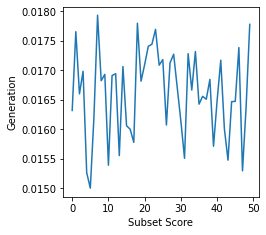

In [75]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.plot(np.linspace(0,49,50), all_options_df.groupby('generation').agg('min')['score'])

ax.set_xlabel('Subset Score')
ax.set_ylabel('Generation')

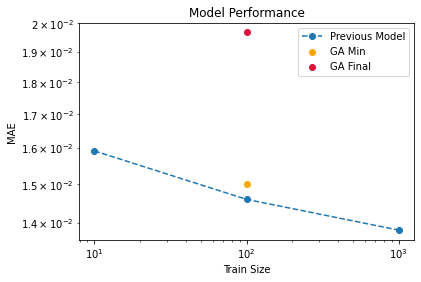

In [96]:
fig, ax = plt.subplots()

ax.loglog(results['train_size'], results['mae'], '--o', label = 'Previous Model')
#p = linregress(np.log(results['train_size'].iloc[-3:]), np.log(results['test_time'].iloc[-3:]))
#ax.text(0.1, 0.8, f'$t \propto N^{{{p[0]:.1f}}}$', transform=ax.transAxes, fontsize=14)
ax.set_ylabel('MAE')
ax.set_title('Model Performance')

ax.scatter(100, all_options_df.agg('min')['score'], color = 'orange', label = 'GA Min')
ax.scatter(100, all_options_df.iloc[-1]['score'], color = 'crimson', label = 'GA Final')

ax.set_xlabel('Train Size')

ax.legend()

- Plot the performance of your optimized model (which would be a single dot in this case) with the learning curve from problem 2. How does it compare?

As shown in the plot, the learning curve from part 2 has a lower MAE and thus, our training method in part 2 is superior to using the Genetic Algorithm for optimization. Even at it's best performance (minimum MAE, orange dot), at a training size of 100 our method from part 2 still outperforms the Genetic Algorith. Furthermore, our *final* score from the Genetic Algorithm (generation 50) is actually far greater than the minimum. Perhaps with more generations our results would improve (evolution does take millenia after all).